<a href="https://colab.research.google.com/github/azz2k/vendor_challenge/blob/main/vendor_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic assumtions and simplifications
* To make my life easier I will remove everything but [a-zA-Z] and whitespaces, which is very restrictive
* For now I will ignore the order of words in text and description as I have limited time
* I'm not going to attempt to use a Transformer for this task as it would take too much time and ressources

# libraries, constants, etc.

In [54]:
from google.colab import drive

import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.decomposition
import sklearn.manifold

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import nltk
import gensim

This should later be put into: requirements installations (in separate requirements file)

In [55]:
# Punkt sentence tokenizer
nltk.download("punkt")
# Word List Corpus
nltk.download("words")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# read data


In [56]:
# mount google drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# read parquet file
products_all_raw_df = pd.read_parquet("/content/drive/MyDrive/Data Science/products.parquet.gz")
products_all_raw_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21z6tu,Cheese Tofu,None,116
1,1,1,w21z74d,Naughty & Nice - Slice,Chocolate - Slice,30
2,2,2,w21xxgu,301. Pork Dumpling with Hot Chilli Vinaigrette...,"6 Pcs, spicy",25
3,3,3,w23b4u1,Mee Kuah,Contain minced mutton meat,45
4,4,4,w21ztq4,Ham & Cheese Sandwich Set,"Toasted to perfection, this sandwich hits all ...",24
...,...,...,...,...,...,...
633143,633143,701,w21zkpm,Sriracha Chicken Whole Wheat Pita,None,22
633144,633144,17,w23b5j9,Dettol Liquid Hand wash Sensitive 250ml,â€¢ Dettol Liquid Hand Wash kills 99.9% of ger...,22
633145,633145,4135,w21ztw0,Red Bean,4 Pcs,22
633146,633146,3121,w21z6vc,Twister Meal,"Choice of 1 Twister, 1 Hash Brown and choice o...",22


# look at target

In [58]:
products_all_raw_df["order_count"].describe()

count    633148.000000
mean          9.482963
std          24.025783
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        1386.000000
Name: order_count, dtype: float64

In [59]:
products_all_raw_df.nlargest(20, "order_count")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
3845,3845,903,w21zs0h,2pc Chickenjoy VM,"2pc Chickenjoy, 1 Side, 1 Drink, 1 Gravy",1386
18078,18078,19,w23b4j4,Chew's Fresh Brown Eggs with Vitamin E 10s x 60g,,1358
21402,21402,19,w23b4j4,Chew's Corn and Soya Fresh Brown Eggs with Vit...,,1277
45838,45838,1421,w21zwre,Chicken Coney Dog with Beef Sauce Combo,"1 Chicken Coney Dog with Beef Sauce, 1 Reg Cur...",1206
3739,3739,36,w21zey6,Anchor Strong Pilsner Beer Can 490ml,With its long standing European heritage and b...,1196
36414,36414,106,w21z6cf,Fresh Banana 5s,Country of Origin: Philippines,1037
22908,22908,1760,w21zg1k,2 pcs Golden Aroma® Chicken Combo,"2 pieces Golden Aroma® Chicken,1 Reg Curly Fri...",996
51321,51321,1421,w21zwre,Mozza Burger® Combo,"1 Mozza Burger® , 1 Reg Curly Fries & 1 Reg A&...",978
44013,44013,1421,w21zwre,2 pcs Golden Aroma® Chicken Combo,"2 pieces Golden Aroma® Chicken,1 Reg Curly Fri...",961
2976,2976,1421,w21zwre,Double Cheeseburger Combo,"1 Double Cheeseburger, 1 Reg Curly Fries & 1 R...",955


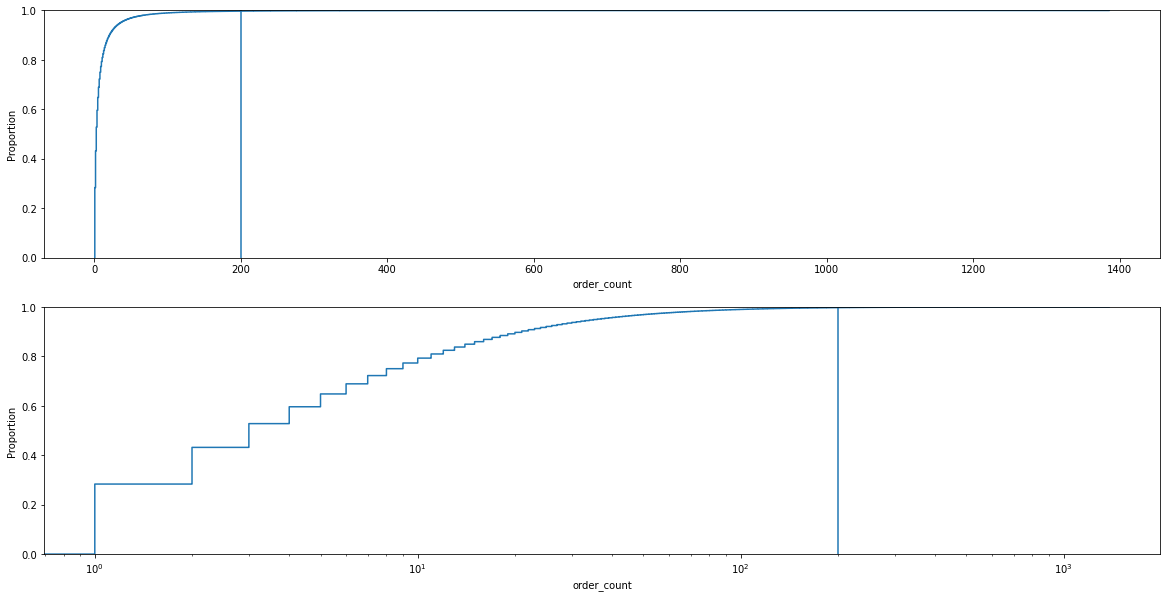

In [60]:
# plot the order count ecdf
fig, ax = plt.subplots(2, 1, figsize = (20, 10))
sns.ecdfplot(
    data=products_all_raw_df,
    x="order_count",
    ax=ax[0]
)
ax[0].axvline(200)
sns.ecdfplot(
    data=products_all_raw_df,
    x="order_count",
    ax=ax[1]
)
ax[1].set_xscale("log")
ax[1].axvline(200)
plt.show()

That is a target distribution we don't really want to see. Most orders are less than five and only a few orders have a significant number. We need to sample from more than just one month to make useful predictions.

We need to apply some transform to order_count, probably log and then clip at 200 or something like that.

# data cleanup

## train test split
For simplicity, we will do the same preprocessing to test and train, which is usually something you have to be really careful doing. However, I'm doing it here for simplicity and because none of the preprocessing steps is using the target.

In [61]:
# sample data for testing
products_sample_raw_df = products_all_raw_df.copy() #sample(20000)

In [62]:
# train test split
products_sample_raw_train_df, products_sample_raw_test_df = sklearn.model_selection.train_test_split(products_sample_raw_df, test_size=0.2)
products_sample_raw_train_df = products_sample_raw_train_df.copy()
products_sample_raw_test_df = products_sample_raw_test_df.copy()
products_sample_raw_train_df["split"] = "train"
products_sample_raw_test_df["split"] = "test"

# put it together for ease of preprocessing
products_sample_raw_train_test_df = pd.concat([products_sample_raw_train_df, products_sample_raw_test_df])
products_sample_raw_train_test_df

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
32167,32167,4024,w21zg1k,Bittergourd Mixed Fish Soup 苦瓜双鱼汤,None,57,train
565505,565505,4480,w21z6vj,Kofta A Gulnaar,Potato and cottage cheese dumplings served in ...,11,train
578975,578975,1889,w21z8vc,Lime Juice 酸柑水,None,12,train
573000,573000,3238,w21zkpu,Lotus Paste Pau,Lotus Paste Pau,12,train
324042,324042,2741,w23b1tq,V9. Seafood Tofu,None,2,train
...,...,...,...,...,...,...,...
525327,525327,5457,w21xxgg,Chocolate Milk,None,8,test
581145,581145,1941,w21zg82,Iced Teh,Freshly brewed black tea with condensed and ev...,13,test
296863,296863,3562,w21z4w1,Cranberry Juice Drink (193320) | 1 L,None,2,test
146035,146035,7353,w21z8mf,Dark Chocolate ( 72% ),None,1,test


## data normalization

In [63]:
# use these keys to normalize
primary_keys = ["product_id", "vendor_id", "vendor_geohash", "split"]
text_keys = primary_keys + ["source"]

In [64]:
# split into a more normalized form
products_raw_df = products_sample_raw_train_test_df[primary_keys + ["order_count"]].copy()
products_name_raw_df = products_sample_raw_train_test_df[primary_keys + ["product_name"]].copy().rename({"product_name": "text"}, axis=1)
products_description_raw_df = products_sample_raw_train_test_df[primary_keys + ["product_description"]].copy().rename({"product_description": "text"}, axis=1)

In [65]:
products_df = products_raw_df.copy()
products_name_df = products_name_raw_df.copy()
products_description_df = products_description_raw_df.copy()

In [66]:
# put it together for ease of preprocessing
products_name_df["source"] = "name"
products_description_df["source"] = "description"
products_text_df = pd.concat([products_name_df, products_description_df])

In [154]:
products_text_df

,product_id,vendor_id,vendor_geohash,split,text,source
32167,32167,4024,w21zg1k,train,bittergourd mixed fish soup,name
565505,565505,4480,w21z6vj,train,kofta gulnaar,name
578975,578975,1889,w21z8vc,train,lime juice,name
573000,573000,3238,w21zkpu,train,lotus paste pau,name
324042,324042,2741,w23b1tq,train,seafood tofu,name
...,...,...,...,...,...,...
492356,492356,2617,w21z7qd,test,juicy quarter pound beef patty dipped in our s...,description
383984,383984,3703,w21zux7,test,the bright smile of sprightly lemon meets the ...,description
630499,630499,869,w23bh25,test,choice of fillings ham cheese onion mushroom c...,description
581145,581145,1941,w21zg82,test,freshly brewed black tea with condensed and ev...,description


## basic cleanup

In [67]:
# drop empty text
products_text_df.dropna(inplace=True)

# replace everything but basic chars for now
products_text_df["text"].replace("[^a-zA-Z ]", " ", inplace=True, regex=True)

# remove single and double characters
products_text_df["text"].replace("(^| ).( |$)", " ", inplace=True, regex=True)

# remove all double whitespaces
products_text_df["text"].replace("[ ]+", " ", inplace=True, regex=True)

# drop empty text
products_text_df["text"].replace("^[ ]+$", "", inplace=True, regex=True)
products_text_df = products_text_df[products_text_df["text"] != ""]

In [68]:
# sanity check
"".join(sorted(set("".join(["".join(set(x)) for x in products_text_df["text"].tolist()]))))

' ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

In [72]:
# to lower
products_text_df["text"] = products_text_df["text"].str.lower()

In [73]:
products_text_df

,product_id,vendor_id,vendor_geohash,split,text,source
32167,32167,4024,w21zg1k,train,bittergourd mixed fish soup,name
565505,565505,4480,w21z6vj,train,kofta gulnaar,name
578975,578975,1889,w21z8vc,train,lime juice,name
573000,573000,3238,w21zkpu,train,lotus paste pau,name
324042,324042,2741,w23b1tq,train,seafood tofu,name
...,...,...,...,...,...,...
492356,492356,2617,w21z7qd,test,juicy quarter pound beef patty dipped in our s...,description
383984,383984,3703,w21zux7,test,the bright smile of sprightly lemon meets the ...,description
630499,630499,869,w23bh25,test,choice of fillings ham cheese onion mushroom c...,description
581145,581145,1941,w21zg82,test,freshly brewed black tea with condensed and ev...,description


## tokenization and stemming

In [74]:
products_text_token_df = products_text_df.copy()

In [75]:
# tokenization
products_text_token_df["text_tokens"] = products_text_token_df["text"].transform(nltk.word_tokenize)

In [76]:
# add a position index and explode
products_text_token_df["idx"] = 1
products_text_token_df = products_text_token_df.explode("text_tokens")
products_text_token_df["idx"] = products_text_token_df.groupby(primary_keys)["idx"].cumsum()

In [77]:
# stemming which we will need later for word2vec
snowball = nltk.stem.SnowballStemmer(language="english")
products_text_token_df["text_tokens_stemmed"] = products_text_token_df["text_tokens"].apply(lambda x: snowball.stem(x))

## filter english items

The general idea here is to count the number of english and total words in name and description and to use this in some way to filter english items.

### checking if tokens are english and couting etc.

In [78]:
# check if text_tokens are in words corpus
words = nltk.corpus.words.words()
products_text_token_df["is_english"] = products_text_token_df["text_tokens"].isin(words)

In [114]:
# count english words and total words and add it back to all items
products_english_df = pd.merge(
    products_text_token_df.groupby(text_keys)["is_english"].sum().reset_index().rename({"is_english": "n_english"}, axis=1),
    products_text_token_df.groupby(text_keys)["is_english"].size().reset_index().rename({"is_english": "n_words"}, axis=1),
    on=text_keys,
    how="outer"
  )

# pivot and fill na with 0 as we are dealing with counts
products_english_df = products_english_df.pivot(index = primary_keys, columns="source", values=["n_english", "n_words"])
products_english_df = products_english_df.fillna(0)

# concat column names
products_english_df.columns = [('{0}_{1}'.format(*tup)) for tup in products_english_df.columns]

# reset index
products_english_df = products_english_df.reset_index()

In [116]:
# calculate the actual frequency = score
products_english_df["n_english_total"] = products_english_df["n_english_description"] + products_english_df["n_english_name"]
products_english_df["n_words_total"] = products_english_df["n_words_description"] + products_english_df["n_words_name"]
products_english_df["english_score"] = products_english_df["n_english_total"] / products_english_df["n_words_total"]

In [117]:
# drop ones with no english score
products_english_df = products_english_df[~products_english_df["english_score"].isna()]

### filter metric exploration

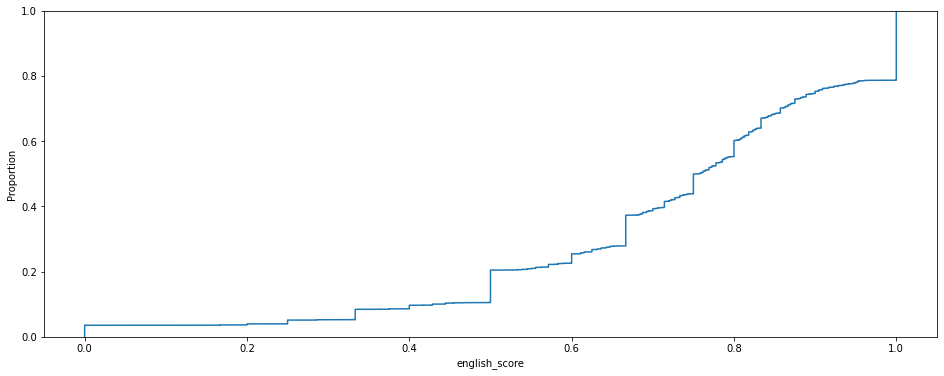

In [118]:
# plot the english score ecdf
fig, ax = plt.subplots(1, 1, figsize=(16,6))
sns.ecdfplot(
    data=products_english_df,
    x="english_score",
    ax=ax
)
plt.show()

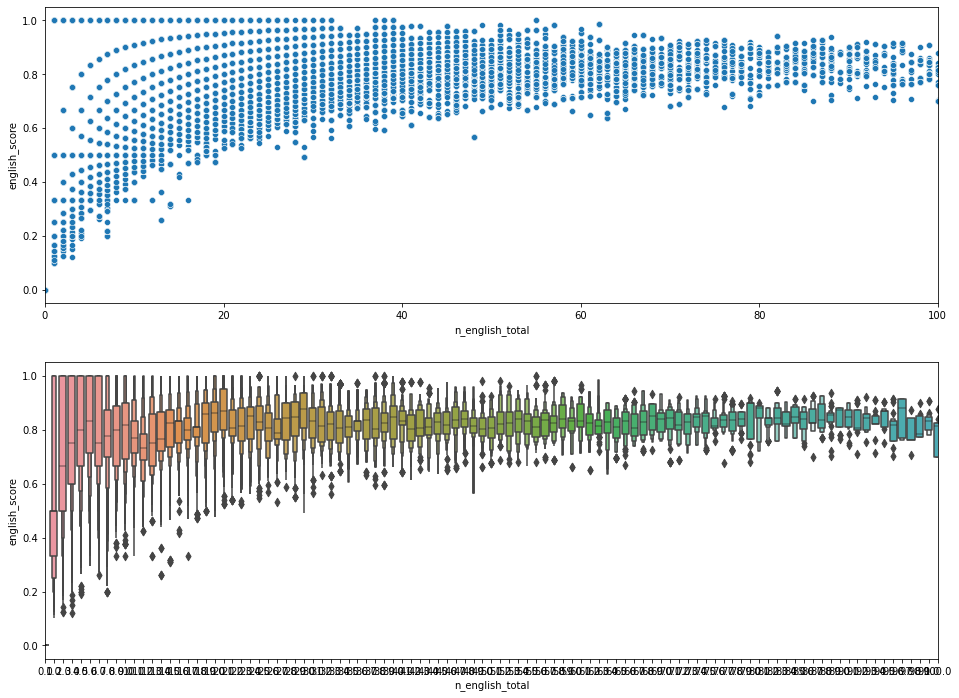

In [121]:
# plot the english score as a function of english words
fig, ax = plt.subplots(2, 1, figsize=(16,12))
sns.scatterplot(
    data=products_english_df,
    x="n_english_total",
    y="english_score",
    ax=ax[0]
)
ax[0].set_xlim(0, 100)

sns.boxenplot(
    data=products_english_df,
    x="n_english_total",
    y="english_score",
    ax=ax[1]
)
ax[1].set_xlim(0, 100)

plt.show()

In [125]:
# original text in score window
products_sample_raw_train_test_df.merge(products_english_df[(products_english_df["english_score"] > 0.2) & (products_english_df["english_score"] < 0.3)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
0,533630,69,w21zv1d,Partyforte Christmas Santa Hat,,9,train
1,544268,357,w21ze1n,CALBEE VEGETABLE FRIES BBQ (5006419) | 45 g,None,9,train
2,483054,5195,w21zs2e,GARDENIA ENWHT BRD JUMBO (5000501) | 600 g,None,6,train
3,781,566,w21z8jt,Char Kway & Tahu,Rojak,36,train
4,494128,45,w21z7z3,Naturel Organic Pasta Fusilli 500g,0,6,train
...,...,...,...,...,...,...,...
8106,244790,3193,w21ztqd,Zaru Noodles,Cold noodles,2,test
8107,112334,2593,w21z6gr,Banh Khot,Vietnamese savoury miniature savoury pancakes,1,test
8108,276934,904,w21z75x,Cha Shu Ramen,4 Pcs,2,test
8109,119064,5873,w21z3jq,HB5. Teriyaki Chicken Burger,None,1,test


In [126]:
# original text in score window
products_sample_raw_train_test_df.merge(products_english_df[(products_english_df["english_score"] > 0.6) & (products_english_df["english_score"] < 0.7)][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
0,565505,4480,w21z6vj,Kofta A Gulnaar,Potato and cottage cheese dumplings served in ...,11,train
1,175778,8599,w21zkpq,Soup Mutton Ribs,None,1,train
2,364149,5874,w21z3yy,German Volkorn Loaf,None,3,train
3,462626,2206,w21z7pb,Toffee Nut Crunch Frappuccino®,Layers of toffee nut blended with toasted nuts...,5,train
4,593890,210,w21zc5q,Cheese Egg Prata,None,14,train
...,...,...,...,...,...,...,...
83656,146600,6037,w21zt06,Claypot Fish Head 砂煲鱼头,None,1,test
83657,438661,39,w21zeqz,Fuel Lean Beast Smoothie,"Coconut water, cherries, beetroot, banana, str...",5,test
83658,509754,69,w21zv1d,Lavazza Nespresso Compatible Capsules Espresso...,"Vigoroso, from Brazilian Arabica and Washed Ro...",7,test
83659,539106,383,w21zerf,Jia Jia Herbal Tea - Less Sugar 6s x 300ml,"Brewed with 11 all-natural herbs, with less su...",9,test


### look at original text with number of english words

In [127]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 0 ][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
0,425344,2117,w21z84z,Mee Kuah,None,4,train
1,7145,285,w23b1w8,Maggie Goreng Combo,None,105,train
2,32925,1709,w21zgtk,Laksa 叻沙,None,78,train
3,161877,2893,w21ztkb,Nescafe Tarik,None,1,train
4,26867,2232,w23b4rs,Steamed Dumplings,6 Pcs,23,train
...,...,...,...,...,...,...,...
22558,294454,3478,w21zv08,Thosai,None,2,test
22559,489664,5744,w21xpjq,Burbousa2,None,6,test
22560,54557,604,w21zscp,Shizuoka Matcha Latte 静岡の抹茶拿铁,None,25,test
22561,80021,547,w21z373,LOACKER MINI NAPOLITANER 125G (5000340),None,1,test


In [128]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 1][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
0,324042,2741,w23b1tq,V9. Seafood Tofu,None,2,train
1,251277,9101,w21ztme,Egg | 10 pieces,None,2,train
2,397801,5702,w21z75x,R404D. Steamed Rice,None,4,train
3,533630,69,w21zv1d,Partyforte Christmas Santa Hat,,9,train
4,230880,5,w21z6dm,Egg Uttapam,None,1,train
...,...,...,...,...,...,...,...
69043,82174,4714,w21z7jy,Vegetable Jalfreeze,None,1,test
69044,619532,937,w23bh2c,Egg Thosai,None,19,test
69045,122658,8028,w23b547,S4. Mixed Vegetables,None,1,test
69046,382142,6287,w21zd30,Iced Teh,None,3,test


In [129]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 2][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
0,578975,1889,w21z8vc,Lime Juice 酸柑水,None,12,train
1,175778,8599,w21zkpq,Soup Mutton Ribs,None,1,train
2,364149,5874,w21z3yy,German Volkorn Loaf,None,3,train
3,417166,5760,w23b4vw,Town Bus Khara Boondi | 150 g,None,4,train
4,510153,3717,w21zt57,ABC Pork Ribs Soup ABC 排骨汤,None,7,train
...,...,...,...,...,...,...,...
97995,191767,6497,w21zgy9,Pokka Blueberry Tea | 500 ml,None,1,test
97996,381862,6139,w21zunh,Green Apple,None,3,test
97997,74321,9252,w21z3uz,Regular Scoop,None,1,test
97998,525327,5457,w21xxgg,Chocolate Milk,None,8,test


In [130]:
products_sample_raw_train_test_df.merge(products_english_df[products_english_df["n_english_total"] == 3][primary_keys], on=primary_keys, how="inner")

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count,split
0,32167,4024,w21zg1k,Bittergourd Mixed Fish Soup 苦瓜双鱼汤,None,57,train
1,546554,3752,w21ze4s,Green Tea Macchiato Medium,None,9,train
2,239714,4019,w21z7hc,Potted Salmon 75g (788915),None,2,train
3,114047,7792,w23b1sy,1. Milky Creamy Prawn 奶皇金沙虾,None,1,train
4,627282,131,w23bhdd,Manora Crab Chips Tin 100g,,21,train
...,...,...,...,...,...,...,...
86321,258005,9164,w21z68x,Fu Rong Fried Omelette 芙蓉蛋,None,2,test
86322,607328,405,w23b4w6,V001. Sweet Potato Leaf 番薯叶,None,16,test
86323,152249,6010,w21z7ht,Egg Plant Chips,None,1,test
86324,510355,36,w21zey6,Evervess Club Soda Cans 4s x 320ml,,7,test


Looks like the english score is not yet good enough. I'll stick for now to "at least one english word", which is also the easiest option. This can always be improved at a later stage.

### actual filtering

In [132]:
products_english_filtered_df = products_english_df.copy()
products_english_filtered_df = products_english_filtered_df[products_english_filtered_df["n_english_total"] > 0]

In [135]:
# how much did we filter?
len(products_sample_raw_train_test_df), len(products_english_filtered_df)

(633148, 610503)

# cleanup verdict
Obviously we could improve our cleanup and subsequent filtering by a lot.

* better character level cleaning
* better dictionary (also include more culinary terms like croissant, alfredo, pepsi, some basic chinese dishes, etc.)
* english filtering is now only done by number of english words, but other metrics could be better (like and improved version of the english score I tried)

For now it seems to be good enough.

# word2vec embedding
I will throw name and description together for the word2vec embedding as I will be averaging the vectors anyway. This is not a very good idea, and doc2vec and so on are better alternatives, but for now I stick to KISS.

In [136]:
doc_keys = primary_keys + ["order_count"]

## gather data

In [147]:
products_doc_df = (
    # start with english products
    products_english_filtered_df[primary_keys]
    # add order_count
    .merge(products_df, on=primary_keys, how="inner")
    # add tokens
    .merge(products_text_token_df, on=primary_keys, how="inner")
    # and merge stemmed tokens into list as word2vec needs it
    .groupby(doc_keys)["text_tokens_stemmed"]
    .agg(list)
    .reset_index())

# only training data
products_doc_df = products_doc_df[products_doc_df["split"] == "train"]

## train embedding

I will ignore hyperparameter tuning of Word2Vec for now. But I'm using CBOW, mainly for speed.

In [153]:
w2v_model = gensim.models.Word2Vec(products_doc_df["text_tokens_stemmed"], sg=0)

In [165]:
# calculate tsne for name embedding
vectors = np.asarray(w2v_model.wv.vectors)

tsne = sklearn.manifold.TSNE(n_components=2)
vectors = tsne.fit_transform(vectors)

vectors_df = pd.DataFrame(vectors, columns=["x", "y"])
vectors_df["label"] = np.asarray(w2v_model.wv.index2entity)

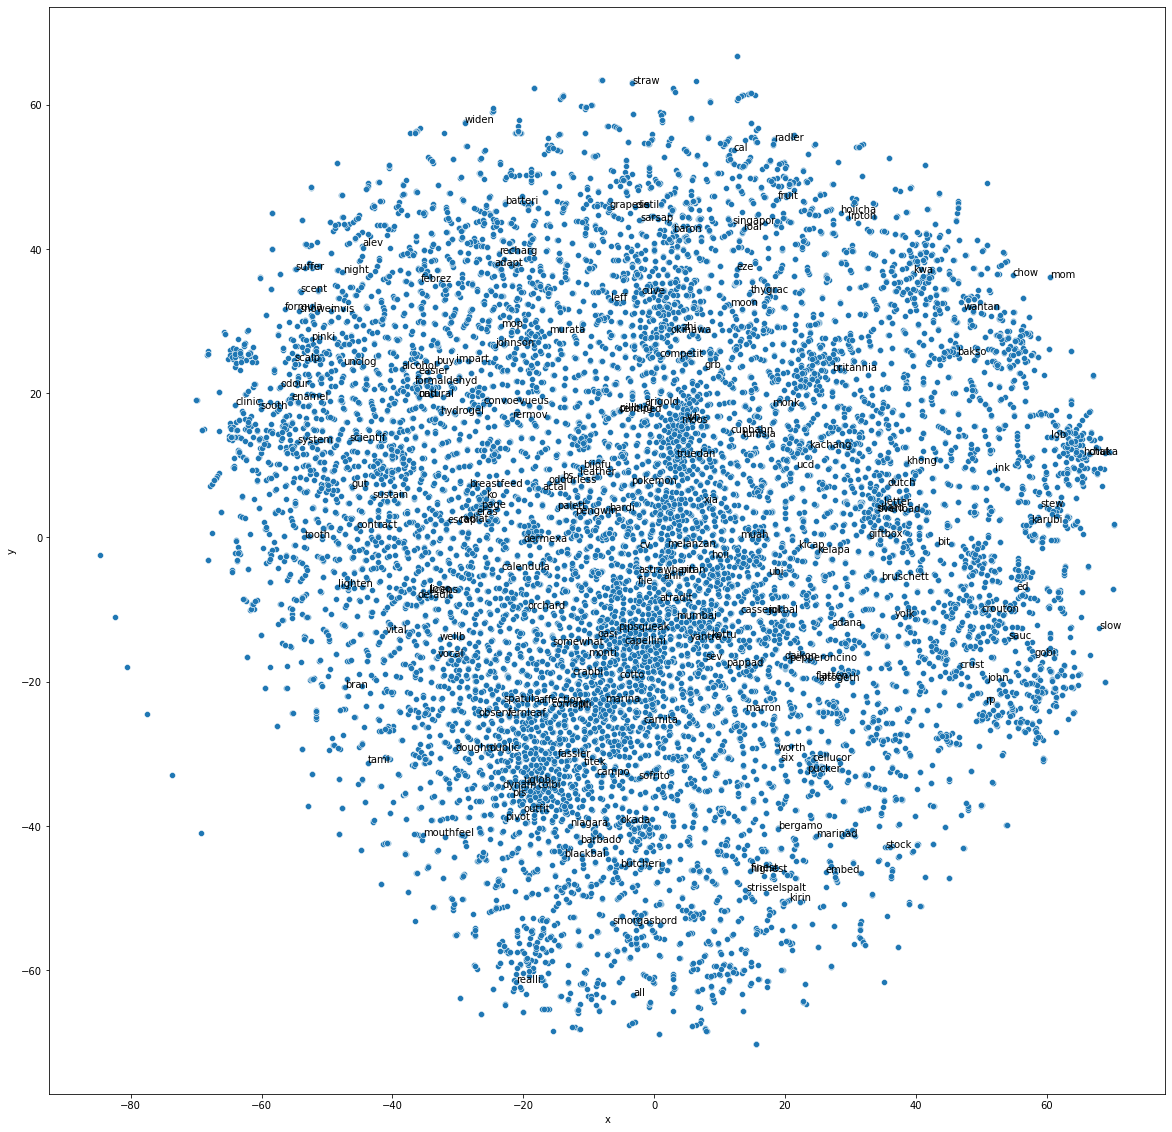

In [166]:
# visualize tsne
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.scatterplot(
    data=vectors_df,
    x="x",
    y="y",
    ax=ax
)
for index, row in vectors_df.sample(200).iterrows():
  plt.annotate(
      s=row["label"],
      xy=(row["x"], row["y"])
  )
plt.show()

## calculate the data embedding

In [156]:
def embed_tokens(tokens, model):
  dims = model.wv["foo"].shape[0]
  vec = np.zeros(dims)
  if type(tokens) is list and len(tokens) > 0:
    vecs = [model.wv[token] for token in tokens if token in model.wv.vocab.keys()]
    if len(vecs) > 0:
      vec = vec + np.mean(vecs, axis=0)
  return vec

In [161]:
products_doc_df["text_vec"] = products_doc_df["text_tokens_stemmed"].apply(lambda x: embed_tokens(x, w2v_model))

In [162]:
products_doc_df

,product_id,vendor_id,vendor_geohash,split,order_count,text_tokens_stemmed,name_vec,text_vec
0,0,0,w21z6tu,train,116,"[chees, tofu]","[1.0679374933242798, -0.5869624614715576, -1.4...","[1.0679374933242798, -0.5869624614715576, -1.4..."
3,3,3,w23b4u1,train,45,"[mee, kuah, contain, minc, mutton, meat]","[0.6978497505187988, 0.6629480123519897, -0.65...","[0.6978497505187988, 0.6629480123519897, -0.65..."
4,4,4,w21ztq4,train,24,"[ham, chees, sandwich, set, toast, to, perfect...","[-0.3792996108531952, 0.019513847306370735, 0....","[-0.3792996108531952, 0.019513847306370735, 0...."
5,5,5,w21z6dm,train,39,"[chicken, dum, biryani, set]","[0.8919803500175476, 0.6662095189094543, -0.21...","[0.8919803500175476, 0.6662095189094543, -0.21..."
7,7,7,w23b1tm,train,53,"[valu, meal, p, great, food, great, valu, come...","[-0.2130984514951706, 0.17973895370960236, -0....","[-0.2130984514951706, 0.17973895370960236, -0...."
...,...,...,...,...,...,...,...,...
610497,633141,36,w21zey6,train,22,"[cocomax, coconut, water, bottl, cocomax, is, ...","[-0.48550939559936523, 0.22683744132518768, -0...","[-0.48550939559936523, 0.22683744132518768, -0..."
610498,633143,701,w21zkpm,train,22,"[sriracha, chicken, whole, wheat, pita]","[0.0010469674598425627, -0.6618824005126953, 0...","[0.0010469674598425627, -0.6618824005126953, 0..."
610499,633144,17,w23b5j9,train,22,"[dettol, liquid, hand, wash, sensit, ml, detto...","[-0.44252142310142517, -0.63292396068573, 0.65...","[-0.44252142310142517, -0.63292396068573, 0.65..."
610500,633145,4135,w21ztw0,train,22,"[red, bean, pcs]","[0.20088577270507812, -0.5526719689369202, -2....","[0.20088577270507812, -0.5526719689369202, -2...."


As discussed in "look at target" we are going to user a log10 clipped at 200 order_count

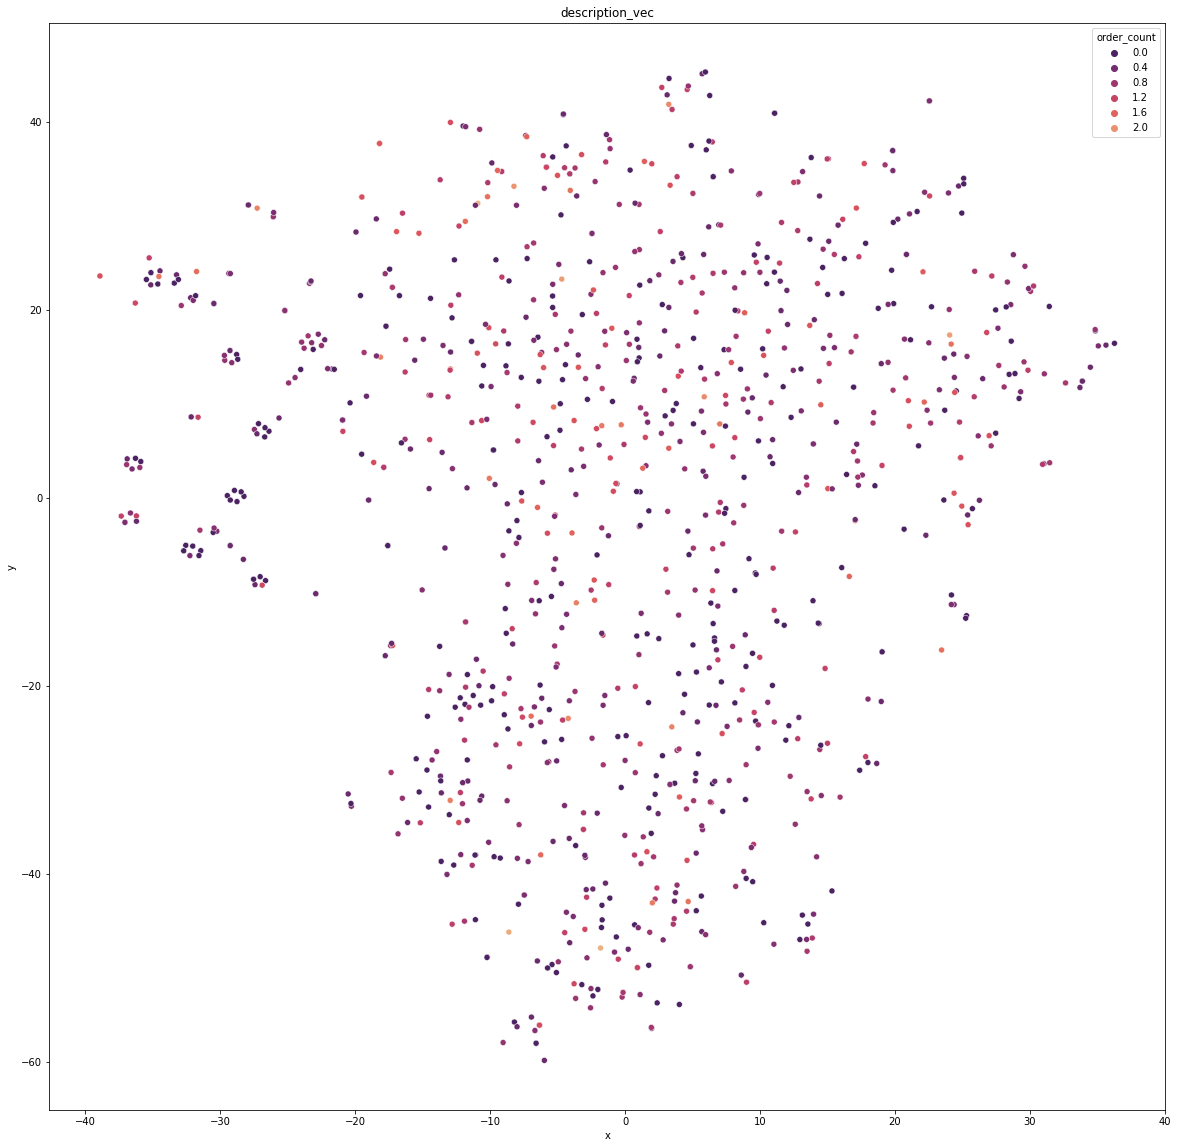

In [164]:
# look at the doc embeddings

products_doc_plot_df = products_doc_df.sample(1000)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
tsne = sklearn.manifold.TSNE(n_components=2)
vectors = tsne.fit_transform(np.vstack(products_doc_plot_df["text_vec"].to_numpy()))

vectors_df = pd.DataFrame(vectors, columns=["x", "y"])
# take care: we dropped the index, so we can't just re-join old data
vectors_df["order_count"] = products_doc_plot_df["order_count"].apply(lambda x: np.log10(np.clip(x, 0, 200))).tolist()

sns.scatterplot(
    data=vectors_df,
    x="x",
    y="y",
    hue="order_count",
    palette="flare_r",
    ax=ax
)
ax.set_title(col)
plt.show()

# Regression

## prepare data for learning

In [ ]:
x = np.vstack(products_doc_df["text_vec"])
y = np.log10(np.clip(products_doc_df["order_count"].to_numpy(), 0, 200))
x.shape, y.shape

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20, 10))

ax[0].hist(x.flatten(), bins=200)
ax[0].set_title("x")

ax[1].hist(x.flatten(), bins=200)
ax[1].set_yscale("log")
ax[1].set_title("x_log")

ax[2].hist(y.flatten(), bins=200)
ax[2].set_title("y")

plt.show()

## baseline